## Redes Neuronales Convolucionales

En este laboratorio, llevaremos a cabo un proceso de entrenamiento para un modelo preexistente desde cero, evitando el uso de transfer learning. En futuros laboratorios, exploraremos y aplicaremos la técnica de transfer learning y fine tuning con el objetivo de mejorar aún más nuestros resultados.

In [2]:
# importamos las librerias que vamos a utilizar en el notebook

import torch # libreria principal
import torch.nn as nn # libreria para redes neuronales
import torch.optim as optim # libreria para optimizacion
from torch.utils.data import DataLoader, Dataset # libreria para cargar los datos
import torchvision.transforms as transforms # libreria para transformar los datos
from torchvision import models # libreria para modelos pre-entrenados
from datasets import load_dataset # libreria para cargar los datos
from tqdm import tqdm # libreria para barra de progreso
import numpy as np # libreria para manejo de matrices

### Dataset

Trabajaremos con una versión reducida del conjunto de datos ImageNet conocida como Tiny ImageNet. Esta variante incluye un conjunto de entrenamiento compuesto por 100,000 ejemplos y un conjunto de prueba de 10,000 ejemplos.

In [31]:
# cargamos el dataset de Tiny ImageNet y lo guardamos en la variable dataset
dataset_ti = load_dataset("zh-plus/tiny-imagenet")

In [32]:
# mostramos la estructura del dataset
dataset_ti

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

### Función para graficar

Esta función se utiliza para visualizar imágenes aleatorias con el fin de tener una idea de los tipos de datos con los que estamos trabajando.

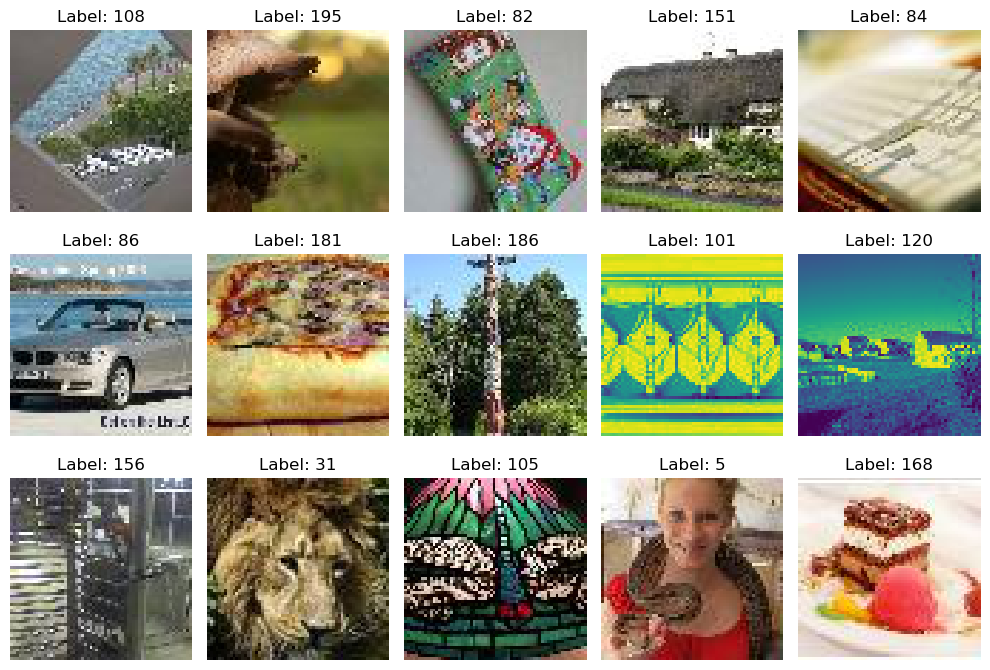

In [33]:
# graficamos algunas imagenes para saber con que tipo de datos estamos trabajando
import matplotlib.pyplot as plt
import random

def show_random_images(dataset, num_rows, num_columns):
    # Crear una figura y ejes para la tabla de imágenes
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 7))

    for i in range(num_rows):
        for j in range(num_columns): 
            # Elegir aleatoriamente una imagen del conjunto de entrenamiento
            random_index = random.randint(0, len(dataset['train']) - 1) 
            random_image = dataset['train'][random_index]['image'] 
            random_label = dataset['train'][random_index]['label'] 

            # Mostrar la imagen en el subgráfico correspondiente
            axes[i, j].imshow(random_image, interpolation='nearest')
            axes[i, j].set_title(f"Label: {random_label}")
            axes[i, j].axis('off')  # Ocultar los ejes

    # Ajustar el espacio entre los subgráficos para que se vean bien
    plt.tight_layout()
    # Mostrar la tabla de imágenes
    plt.show()

# Llamar a la función con tu dataset
show_random_images(dataset_ti, 3, 5)


### Transformaciones 

En esta sección, implementamos algunas transformaciones que deseamos aplicar a las imágenes. En nuestro caso, estas transformaciones incluyen las siguientes:

In [34]:
# Definir una transformación para el preprocesamiento de imágenes.
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # pasar a escala de grises (3 canales)
    transforms.Resize((64, 64)), # redimensionar a 64x64
    transforms.ToTensor(), # convertir a tensor
])

### Dataset Custom

Esta clase facilitará el manejo de nuestro conjunto de datos, simplificando las operaciones y la interacción con él.

In [35]:
# Defina su clase de conjunto de datos personalizado
class CustomDataset(Dataset):
    def __init__(self, dataset, split, transform=None):
        self.X = dataset[split]['image'] # cargar imágenes
        self.y = dataset[split]['label'] # cargar etiquetas
        self.transform = transform

    # Devuelve el número de muestras en el conjunto de datos.
    def __len__(self):
        return len(self.X)

    # Devuelve una muestra del conjunto de datos en la posición index.
    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [36]:
# Creamos el conjunto de datos de entrenamiento y de prueba con la clase CustomDataset que definimos anteriormente 
dataset = {
    'train' : CustomDataset(dataset_ti, 'train', transform=transform),
    'test' : CustomDataset(dataset_ti, 'valid', transform=transform),
}

len(dataset['train']), len(dataset['test'])

(100000, 10000)

Estamos mostrando una imagen para determinar si está normalizadas o no.

In [37]:
dataset['train'][0]

(tensor([[[0.7020, 0.7059, 0.7176,  ..., 0.8941, 0.9059, 0.5961],
          [0.6706, 0.6784, 0.6902,  ..., 0.8745, 0.8784, 0.5804],
          [0.6745, 0.6824, 0.6980,  ..., 0.8824, 0.8784, 0.5647],
          ...,
          [0.4235, 0.4157, 0.4078,  ..., 0.2941, 0.2667, 0.3294],
          [0.4039, 0.4000, 0.3922,  ..., 0.2980, 0.2627, 0.3020],
          [0.4118, 0.4118, 0.4078,  ..., 0.3373, 0.2627, 0.2431]],
 
         [[0.7020, 0.7059, 0.7176,  ..., 0.8941, 0.9059, 0.5961],
          [0.6706, 0.6784, 0.6902,  ..., 0.8745, 0.8784, 0.5804],
          [0.6745, 0.6824, 0.6980,  ..., 0.8824, 0.8784, 0.5647],
          ...,
          [0.4235, 0.4157, 0.4078,  ..., 0.2941, 0.2667, 0.3294],
          [0.4039, 0.4000, 0.3922,  ..., 0.2980, 0.2627, 0.3020],
          [0.4118, 0.4118, 0.4078,  ..., 0.3373, 0.2627, 0.2431]],
 
         [[0.7020, 0.7059, 0.7176,  ..., 0.8941, 0.9059, 0.5961],
          [0.6706, 0.6784, 0.6902,  ..., 0.8745, 0.8784, 0.5804],
          [0.6745, 0.6824, 0.6980,  ...,

In [38]:
# Inicializa las variables para el valor máximo y mínimo
max_value = float('-inf')  # Inicializa con un valor negativo infinito
min_value = float('inf')   # Inicializa con un valor positivo infinito

# Itera a través de los lotes en el DataLoader
for batch in dataset['train']:
    # Desempaqueta el lote en características (X) y etiquetas (y)
    X, y = batch
    
    # Encuentra el valor máximo y mínimo en el lote actual
    batch_max = torch.max(X)
    batch_min = torch.min(X)
    
    # Actualiza el valor máximo y mínimo global si es necesario
    max_value = max(max_value, batch_max)
    min_value = min(min_value, batch_min)

# Ahora 'max_value' contiene el valor máximo en todo el conjunto de datos
# y 'min_value' contiene el valor mínimo en todo el conjunto de datos.

print(f"Valor máximo: {max_value}")
print(f"Valor mínimo: {min_value}")

Valor máximo: 1.0
Valor mínimo: 0.0


En este caso, el conjunto de datos se encuentra ya normalizado, por lo tanto, no es necesario realizar ninguna normalización adicional. Las imágenes están listas para ser utilizadas en el proceso de entrenamiento.

### Dataloader

Hemos creado un DataLoader personalizado para gestionar nuestros datos de manera más eficiente y conveniente. Esto nos permitirá realizar un mejor manejo de los datos al cargarlos y procesarlos de manera adecuada para el entrenamiento de nuestro modelo ResNeXt50 desde cero.

In [44]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape, labels.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

### Modelo pre entrenado

Vamos a utilizar el modelo ResNeXt50 en este laboratorio. La elección de este modelo se debe a sus capacidades y rendimiento probados en tareas de visión por computadora. ResNeXt50 es conocido por su profundidad y habilidad para aprender representaciones de alta calidad de datos visuales complejos.

Dado que nuestro conjunto de datos ya está normalizado y listo para el entrenamiento, la elección de ResNeXt50 nos brinda una base sólida para abordar nuestra tarea de clasificación de imágenes con confianza.

In [46]:
# Cargar el modelo preentrenado resnext50_32x4d
model = models.resnext50_32x4d(pretrained=True)
model # mostramos la estructura del modelo

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [47]:
# cambiamos la capa de salida de la red por una capa lineal con 200 neuronas (número de clases)
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [48]:
# cambiar la última capa de salida de la red para que coincida con el número de clases en el conjunto de datos
model._fc = nn.Linear(2048, 200) # cambiamos a 200 clases de salida

In [49]:
# miramos la nueva arquitectura de la red neuronal convolucional pre-entrenada (ResNet50)
model._fc

Linear(in_features=2048, out_features=200, bias=True)

### Entreamiento

Hemos implementado la función `fit` para entrenar nuestro modelo, tal como mencionamos anteriormente. En este caso, estamos realizando un entrenamiento desde cero de nuestra red neuronal basada en el modelo ResNeXt50.

In [53]:
# definimos la función de entrenamiento
from sklearn.metrics import accuracy_score

def fit(model, dataloader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    
    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        train_loss, train_pred, train_true = [], [], []
        bar = tqdm(dataloader['train'])
        
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
            # Calcula las predicciones y etiquetas verdaderas para calcular la precisión
            train_pred.extend(torch.argmax(y_hat, axis=1).cpu().numpy())
            train_true.extend(y.cpu().numpy())
            
            bar.set_description(f"loss {np.mean(train_loss):.5f}")
        
        train_accuracy = accuracy_score(train_true, train_pred)
        train_losses.append(np.mean(train_loss))
        train_accs.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss, val_pred, val_true = [], [], []
        bar = tqdm(dataloader['test'])
        
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                
                # Calcula las predicciones y etiquetas verdaderas para calcular la precisión
                val_pred.extend(torch.argmax(y_hat, axis=1).cpu().numpy())
                val_true.extend(y.cpu().numpy())
                
                bar.set_description(f"val_loss {np.mean(val_loss):.5f}")
        
        val_accuracy = accuracy_score(val_true, val_pred)
        val_losses.append(np.mean(val_loss))
        val_accs.append(val_accuracy)
        
        print(f"Epoch {epoch}/{epochs} - Train Loss: {train_losses[-1]:.5f} - Train Accuracy: {train_accs[-1]:.5f} - Val Loss: {val_losses[-1]:.5f} - Val Accuracy: {val_accs[-1]:.5f}")
    
    return train_losses, train_accs, val_losses, val_accs

# Llama a la función con tu modelo, dataloader y otros parámetros
train_losses, train_accs, val_losses, val_accs = fit(model, dataloader, epochs=8)

val_loss 2.90965: 100%|██████████| 40/40 [00:05<00:00,  7.92it/s]


Epoch 1/8 - Train Loss: 2.87734 - Train Accuracy: 0.31920 - Val Loss: 2.90965 - Val Accuracy: 0.31430


val_loss 2.74214: 100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


Epoch 2/8 - Train Loss: 2.46951 - Train Accuracy: 0.39750 - Val Loss: 2.74214 - Val Accuracy: 0.35750


val_loss 2.78260: 100%|██████████| 40/40 [00:05<00:00,  7.98it/s]


Epoch 3/8 - Train Loss: 2.20884 - Train Accuracy: 0.45189 - Val Loss: 2.78260 - Val Accuracy: 0.35230


val_loss 2.67768: 100%|██████████| 40/40 [00:05<00:00,  7.95it/s]


Epoch 4/8 - Train Loss: 1.88440 - Train Accuracy: 0.51990 - Val Loss: 2.67768 - Val Accuracy: 0.39000


val_loss 2.88835: 100%|██████████| 40/40 [00:05<00:00,  7.96it/s]


Epoch 5/8 - Train Loss: 1.46387 - Train Accuracy: 0.61223 - Val Loss: 2.88835 - Val Accuracy: 0.36960


val_loss 2.97973: 100%|██████████| 40/40 [00:05<00:00,  8.00it/s]


Epoch 6/8 - Train Loss: 1.11219 - Train Accuracy: 0.69384 - Val Loss: 2.97973 - Val Accuracy: 0.37610


val_loss 2.91238: 100%|██████████| 40/40 [00:04<00:00,  8.02it/s]


Epoch 7/8 - Train Loss: 0.90798 - Train Accuracy: 0.74582 - Val Loss: 2.91238 - Val Accuracy: 0.39370


val_loss 3.36173: 100%|██████████| 40/40 [00:05<00:00,  7.85it/s]

Epoch 8/8 - Train Loss: 0.50814 - Train Accuracy: 0.85321 - Val Loss: 3.36173 - Val Accuracy: 0.37270


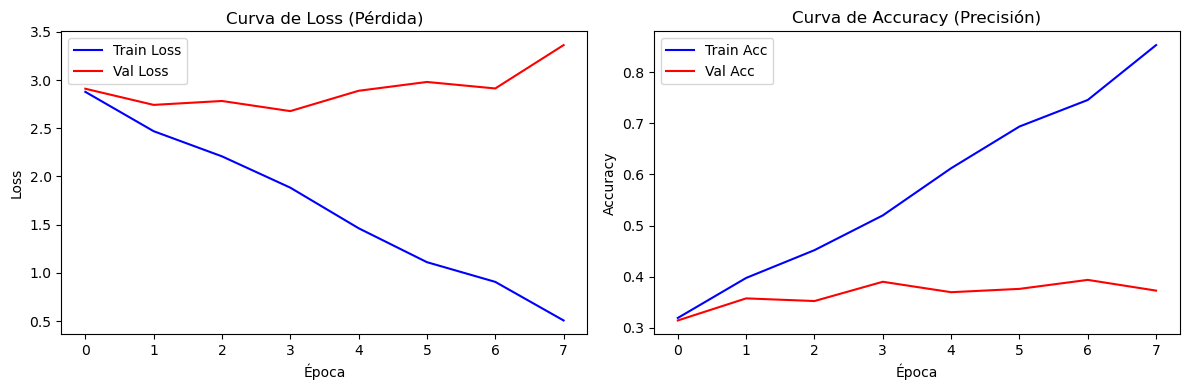

In [54]:
# Los valores de train_losses, val_losses, train_accs y val_accs deben estar disponibles desde tu entrenamiento previo.

# Crear una figura con dos subtramas en una fila y dos columnas
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1: Loss (pérdida)
axs[0].plot(train_losses, label='Train Loss', color='blue')
axs[0].plot(val_losses, label='Val Loss', color='red')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Loss')
axs[0].set_title('Curva de Loss (Pérdida)')
axs[0].legend()

# Gráfico 2: Accuracy (precisión)
axs[1].plot(train_accs, label='Train Acc', color='blue')
axs[1].plot(val_accs, label='Val Acc', color='red')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Curva de Accuracy (Precisión)')
axs[1].legend()

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

In [79]:
# guardamos el modelo
torch.save(model.state_dict(), '/modelo_pre_entrenado_efficientnet-b0.pth')

In [ ]:
# cargamos el modelo
# definimos el modelo
model = models.resnext50_32x4d(pretrained=True)
model._fc = nn.Linear(2048, 200) # cambiamos a 200 clases de salida
model.load_state_dict(torch.load('/modelo_pre_entrenado_resnet50.pth'))
model.eval()